--- Synthetic Supply Chain Data Head ---
   demand_forecast  historical_sales_3m_avg  promo_event_active  \
0              152               153.998252                   0   
1              485               462.401742                   0   
2              398               428.138947                   0   
3              320               339.035265                   1   
4              156               160.943697                   0   

   supplier_lead_time_days  supplier_reliability_score  current_inventory  \
0                       13                    0.827438                307   
1                       19                    0.815666                251   
2                        9                    0.974625                  7   
3                       17                    0.928580                767   
4                        9                    0.851535                874   

   warehouse_capacity_utilization  unit_cost  shipping_cost_per_unit  month  \
0             

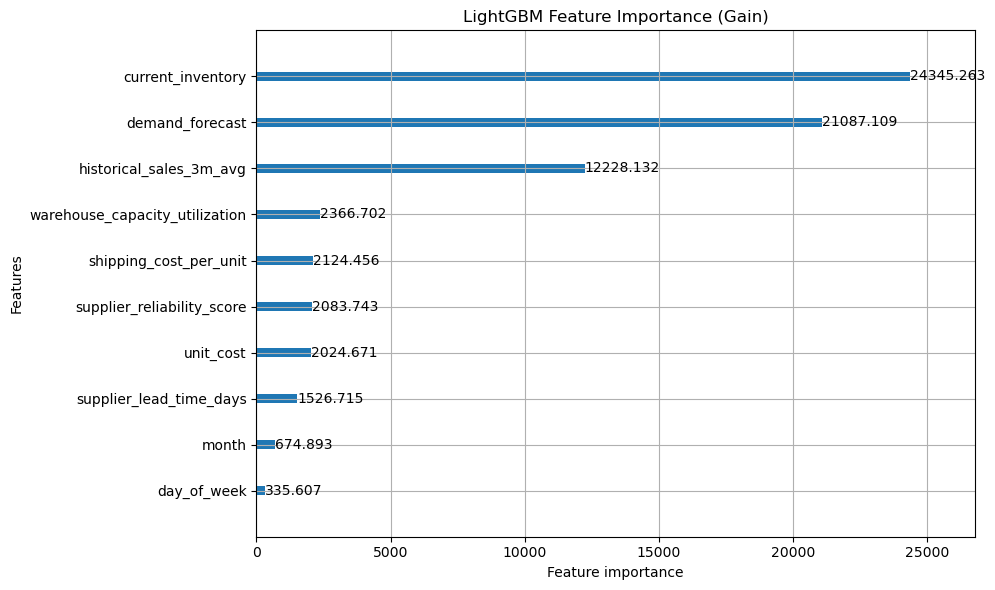

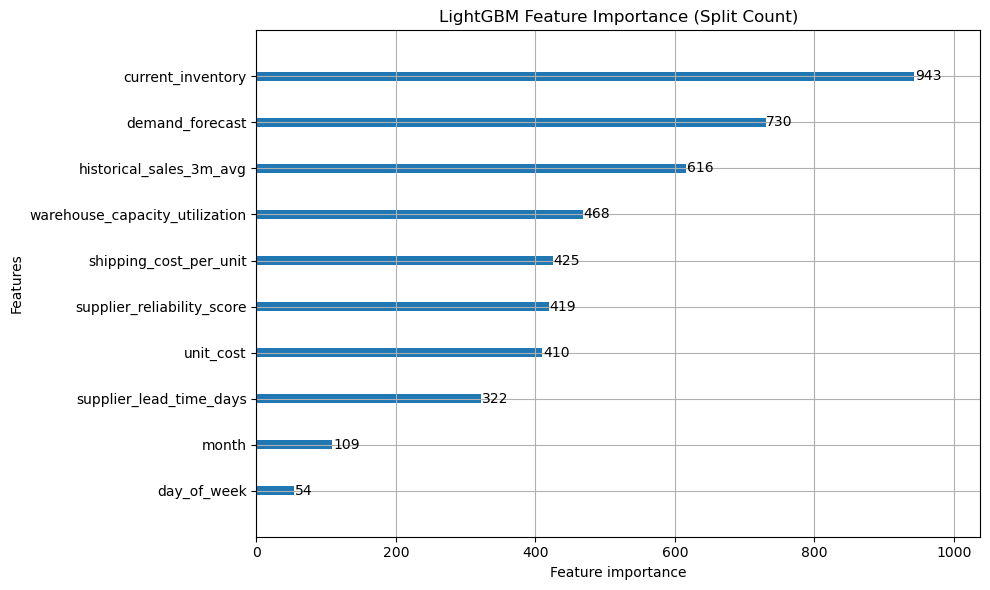

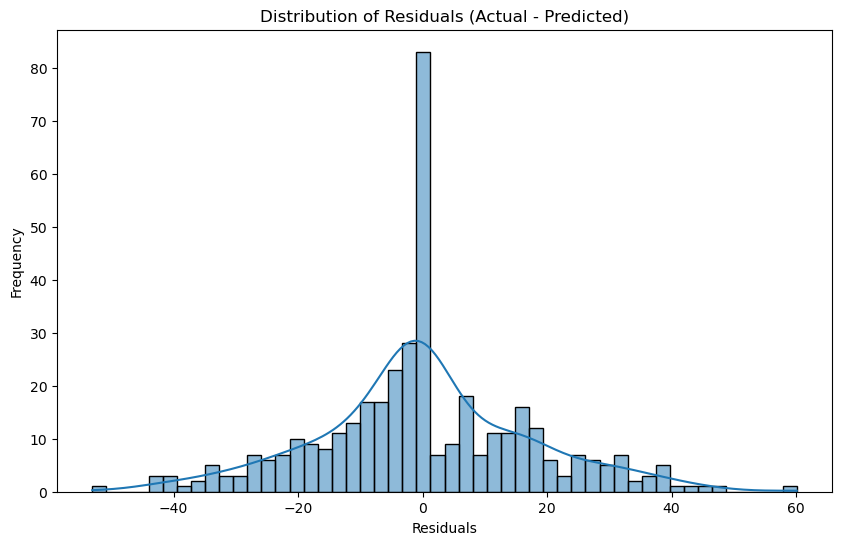

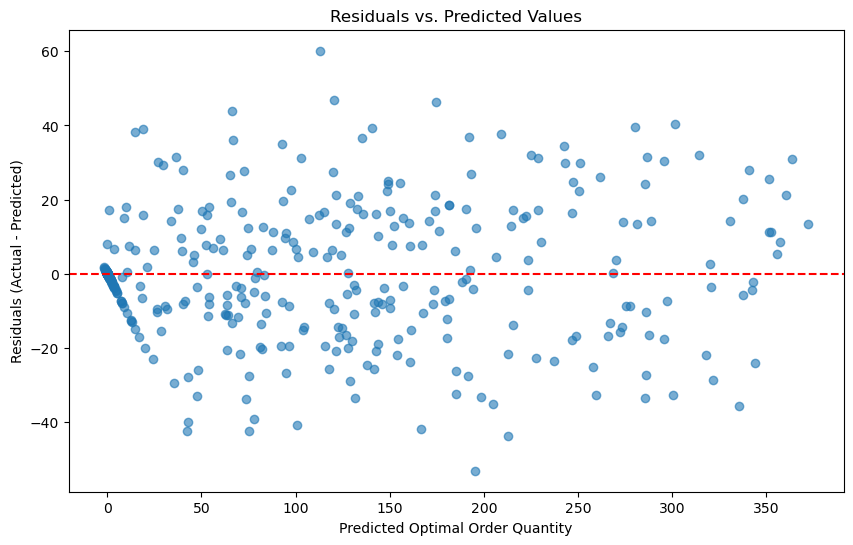

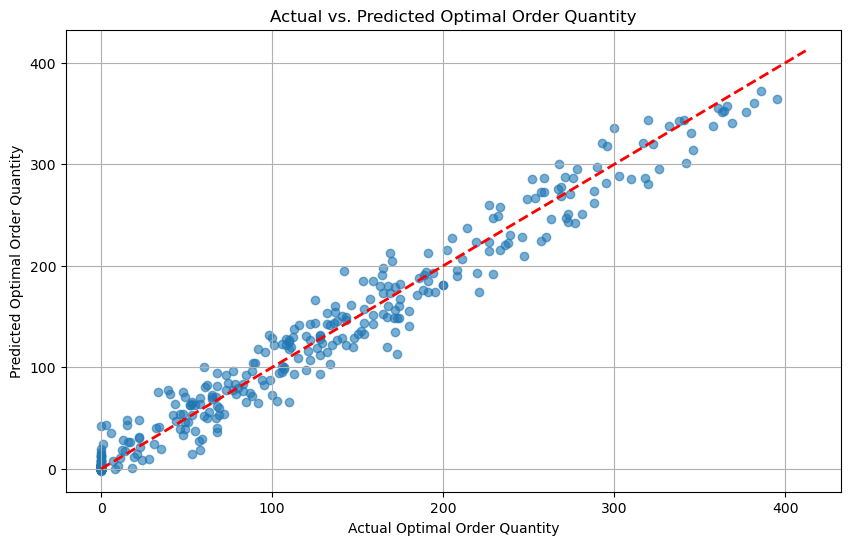


Attempting to visualize the first decision tree (requires graphviz)...
Could not visualize tree: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

--- Visualizations Complete ---


In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import plot_importance, create_tree_digraph

# --- 1. Generate Synthetic Supply Chain Data ---
def generate_supply_chain_data(num_samples=1000):
    np.random.seed(42)
    data = {}

    # Demand-related features
    data['demand_forecast'] = np.random.randint(50, 500, num_samples)
    data['historical_sales_3m_avg'] = data['demand_forecast'] * (1 + np.random.uniform(-0.1, 0.1, num_samples))
    data['promo_event_active'] = np.random.choice([0, 1], num_samples, p=[0.8, 0.2])

    # Supplier-related features
    data['supplier_lead_time_days'] = np.random.randint(5, 30, num_samples)
    data['supplier_reliability_score'] = np.random.uniform(0.7, 1.0, num_samples)

    # Inventory-related features
    data['current_inventory'] = np.random.randint(0, 1000, num_samples)
    data['warehouse_capacity_utilization'] = np.random.uniform(0.3, 0.9, num_samples)

    # Cost-related features
    data['unit_cost'] = np.random.uniform(10, 100, num_samples)
    data['shipping_cost_per_unit'] = np.random.uniform(1, 10, num_samples)

    # Time-related features (e.g., day of week, month)
    data['month'] = np.random.randint(1, 13, num_samples)
    data['day_of_week'] = np.random.randint(0, 7, num_samples)

    # Target variable: Optimal Order Quantity
    # Let's create a simplified relationship for the target
    # Factors influencing order quantity: demand, lead time, current inventory, promo events
    optimal_order_quantity = (
        0.6 * data['demand_forecast'] +
        0.2 * data['historical_sales_3m_avg'] -
        0.3 * data['current_inventory'] +
        0.1 * data['promo_event_active'] * 50 + # Promo increases order
        0.05 * data['supplier_lead_time_days'] * 10 + # Longer lead time might mean larger buffer
        np.random.normal(0, 20, num_samples) # Add some noise
    )
    # Ensure order quantity is not negative
    data['optimal_order_quantity'] = np.maximum(0, optimal_order_quantity).astype(int)

    df = pd.DataFrame(data)
    return df

supply_chain_df = generate_supply_chain_data(num_samples=2000)
print("--- Synthetic Supply Chain Data Head ---")
print(supply_chain_df.head())
print("\n--- Synthetic Supply Chain Data Description ---")
print(supply_chain_df.describe())

# --- 2. Prepare Data for LightGBM ---
X = supply_chain_df.drop('optimal_order_quantity', axis=1)
y = supply_chain_df['optimal_order_quantity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Define categorical features explicitly for LightGBM
# This helps LightGBM treat them appropriately without one-hot encoding
categorical_features = ['promo_event_active', 'month', 'day_of_week']
for col in categorical_features:
    if col in X.columns:
        X_train[col] = X_train[col].astype('category')
        X_test[col] = X_test[col].astype('category')

# --- 3. Train LightGBM Model ---
print("\n--- Training LightGBM Model ---")
lgb_params = {
    'objective': 'regression_l1', # MAE objective
    'metric': 'mae',
    'n_estimators': 200,
    'learning_rate': 0.05,
    'feature_fraction': 0.8, # Fraction of features to consider at each split
    'bagging_fraction': 0.8, # Fraction of data to sample for each tree
    'bagging_freq': 1,
    'verbose': -1, # Suppress verbose output
    'n_jobs': -1, # Use all available cores
    'seed': 42
}

model = lgb.LGBMRegressor(**lgb_params)
model.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          eval_metric='mae',
          callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=False)])

print("\n--- Model Training Complete ---")

# --- 4. Evaluate Model ---
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error on Test Set: {mse:.2f}")
print(f"R-squared on Test Set: {r2:.2f}")

# --- 5. Visualizations ---

print("\n--- Generating Visualizations ---")

# 5.1 Feature Importance Plot
# LightGBM has a built-in function for this.
# 'type' can be 'split' (number of times a feature is used in a split)
# or 'gain' (total gain of splits involving the feature)
fig, ax = plt.subplots(figsize=(10, 6))
plot_importance(model, ax=ax, importance_type='gain', max_num_features=10, title='LightGBM Feature Importance (Gain)')
plt.tight_layout()
plt.show()
# This plot shows which features contributed most to reducing the error (gain) or were used most often (split)
# The higher the value, the more important the feature to the model's predictions.

fig, ax = plt.subplots(figsize=(10, 6))
plot_importance(model, ax=ax, importance_type='split', max_num_features=10, title='LightGBM Feature Importance (Split Count)')
plt.tight_layout()
plt.show()
# This plot shows which features were used most frequently for splitting nodes in the trees.


# 5.2 Residuals Plot (using matplotlib/seaborn)
# This helps us understand the model's errors.
# Ideally, residuals should be randomly distributed around zero.
plt.figure(figsize=(10, 6))
sns.histplot(y_test - y_pred, kde=True, bins=50)
plt.title('Distribution of Residuals (Actual - Predicted)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()
# A good model will have residuals centered around zero and normally distributed.

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, y_test - y_pred, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Optimal Order Quantity')
plt.ylabel('Residuals (Actual - Predicted)')
plt.show()
# This plot helps identify patterns in errors. If you see a shape (e.g., a funnel or a curve),
# it suggests the model might be systematically under- or over-predicting for certain ranges.


# 5.3 Actual vs. Predicted Plot (using matplotlib/seaborn)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2) # Ideal prediction line
plt.xlabel('Actual Optimal Order Quantity')
plt.ylabel('Predicted Optimal Order Quantity')
plt.title('Actual vs. Predicted Optimal Order Quantity')
plt.grid(True)
plt.show()
# The closer the points are to the red diagonal line, the better the model's predictions.


# 5.4 Plotting a Single Decision Tree (requires graphviz)
# This is mainly for illustration, as real-world LightGBM models have hundreds of complex trees.
# You might need to install graphviz: pip install graphviz
try:
    # Use create_tree_digraph to get a graphviz Digraph object
    # num_trees is the index of the tree to plot (0-indexed)
    # The output is a graphviz.Digraph object, which can be rendered.
    print("\nAttempting to visualize the first decision tree (requires graphviz)...")
    graph = create_tree_digraph(model, tree_index=0, show_info=['split_feature', 'split_gain', 'leaf_value'])
    # To save as a file: graph.render('lgbm_tree_0', view=True, format='png')
    # Or to display it in a Jupyter/IPython environment, just output 'graph'
    # For a simple script, we'll try to save it and mention how to view it.

    # If running in an environment where graphviz can render directly (e.g., Jupyter Notebook)
    # the 'graph' object would render itself if it's the last line of a cell.
    # In a script, you typically save it to a file.
    graph.render(filename='lgbm_tree_0', view=False, format='png', cleanup=True)
    print("Decision tree saved as 'lgbm_tree_0.png'. Open the file to view it.")
    # You can also generate an SVG if you want a scalable image:
    # graph.render(filename='lgbm_tree_0', view=False, format='svg', cleanup=True)
    # print("Decision tree saved as 'lgbm_tree_0.svg'.")
except ImportError:
    print("Graphviz is not installed. To visualize individual trees, please install it: pip install graphviz")
except Exception as e:
    print(f"Could not visualize tree: {e}")

print("\n--- Visualizations Complete ---")